In [38]:
import os
import gc
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mock_FRB_follow-up

In [10]:
# Define some plotting variables.
textwidth = 7.0282  # might also be from latex textwidth=17.85162cm columnwidth=8.5744cm
columnwidth = 3.37574803  #3.3

small_size = 8
medium_size = 10
bigger_size = 12

sns.set_theme(style="ticks", context="paper")

plt.rc('font', size=small_size)          # controls default text sizes
plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_size)    # legend fontsize
plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title

In [14]:
# energy_high = 10**41.40
# specif_lum_high = energy_high/(1e9*0.00267)
# spectral_index = -0.65
# freq_low, freq_high = 100e6, 50e9
# freq_factor = (freq_high**(1+spectral_index) - freq_low**(1+spectral_index))/1.3e9**spectral_index
# # luminosity_low = bol_lum_low  # bol_lum_low * freq_factor
# luminosity_high = specif_lum_high * freq_factor
# specif_lum_high*(1.4e9/1.3e9)**spectral_index

(8.965379844540323e+34, 3.888870236857153e+44)

In [15]:
# Compare the luminosity values obtained from different papers.
# Energy from Shin et al. 2022 also in a 1GHz band, but probably at 600MHz
print(10**41.29/(1e9*0.001))  # 1GHz bandwidth mean at CHIME is ~1ms
print(np.log10(10**41.29/(1e9*0.001)*(1.3/0.6)**(-.65)))  # shift it to 1.3 GHz
print(10**41.76/(1e9*0.001)*(1.3/0.6)**(-.65))  # shift it to 1.3 GHz
print(10**40.83/(1e9*0.001)*(1.3/0.6)**(-.65))  # shift it to 1.3 GHz
print(10**41.40/(1e9*0.00549))  # James plus their width mu
print(10**41.40/(1e9*0.00267))  # James plus Arcus width mu
E_James = np.log10(10**41.88/(1e9*0.00267))
print(E_James)  # James with uniform prior plus Arcus width mu
print(np.log10(10**(41.88+.24)/(1e9*0.00267))-E_James)  # James with uniform prior plus Arcus width mu
print(np.log10(10**(41.88-.48)/(1e9*0.00267))-E_James)  # James with uniform prior plus Arcus width mu
# Hashimoto
print(np.log10(1e33*(1.3/1.83)**-.65/(2.8e-3)))

1.9498445997580413e+35
35.071735133749925
3.481249368606615e+35
4.090111371310695e+34
4.575385121146761e+34
9.407814350223115e+34
35.45348873863543
0.240000000000002
-0.4799999999999969


In [33]:
# Define the telescope and FRB population parameters that are not kept the same.
# 
# ASKAP
# survey_model, beam_model = 'askap-incoh', 'gaussian'
# z_model, z_max, bol_lum_low = 'sfr', 1., 2e40       # Available: 'vol_co', 'sfr', 'smd'
# z_model, z_max, bol_lum_low = 'smd', 1., 8e39
# z_model, z_max, bol_lum_low = 'vol_co', 1., 5e39

# ASKAP-CRACO
survey_model, beam_model = 'askap-incoh', 'gaussian'
survey = Survey(survey_model)
survey.gain *= 4.4
survey.bw = 288
survey_model = survey
z_model, z_max, bol_lum_low = 'sfr', 2.5, 8e39
# z_model, z_max, bol_lum_low = 'smd', 1.8, 2e39
# z_model, z_max, bol_lum_low = 'vol_co', 2., 3e39

# chord
# survey_model, beam_model = 'chord', 'chime-frb'
# z_model, z_max, bol_lum_low = 'sfr', 4.5, 1e41
#z_model, z_max, bol_lum_low = 'smd', 4., 1e40
#z_model, z_max, bol_lum_low = 'vol_co', 5., 5e40

# Meerkat (values in frbpoppy seem to be placeholders)
#survey_model, beam_model = 'meerkat', 'gaussian'
#z_model, z_max, bol_lum_low = 'sfr', 1.5, 1e40
#z_model, z_max, bol_lum_low = 'smd', 1.5, 1e40
#z_model, z_max, bol_lum_low = 'vol_co', 2., 1e40

# SKA1-mid
# survey_model, beam_model = 'ska1-mid', 'gaussian'
# z_model, z_max, bol_lum_low = 'sfr', 6.5, 1e39
#z_model, z_max, bol_lum_low = 'smd', 6.5, 1e38
#z_model, z_max, bol_lum_low = 'vol_co', 6.5, 5e37

# CHIME
# survey_model, beam_model = 'chime-frb', 'chime-frb'
# z_model, z_max, bol_lum_low = 'sfr', 2.5, 5e41
# z_model, z_max, bol_lum_low = 'smd', 2., 5e40
# z_model, z_max, bol_lum_low = 'vol_co', 2., 8e40

In [25]:
all_runs = [
    # ASKAP
    # ['askap-incoh', 'gaussian', 'sfr', 1.2, 2e40],
    # ['askap-incoh', 'gaussian', 'smd', 1.2, 8e39],
    # ['askap-incoh', 'gaussian', 'vol_co', 1.2, 5e39],
    # # CHIME
    ['chime-frb', 'chime-frb', 'sfr', 3.5, 1e41],
    # ['chime-frb', 'chime-frb', 'smd', 2.2, 1e40],
    # ['chime-frb', 'chime-frb', 'vol_co', 2.8, 3e40],
    # Meerkat
    # ['meerkat', 'gaussian', 'sfr', 1., 1e40],
    # ['meerkat', 'gaussian', 'smd', 1.2, 5e39],
    # ['meerkat', 'gaussian', 'vol_co', 1.2, 1e40],
    # SKA1-mid
    # ['ska1-mid', 'gaussian', 'sfr', 6., 3e37],
    # ['ska1-mid', 'gaussian', 'smd', 5., 4e36],
    # ['ska1-mid', 'gaussian', 'vol_co', 6., 3e37],
]

In [21]:
# For comparison
james_frbs = np.array([186.7, 15.9, 0.15, 898.1, 32.2, 0.718, 1179.5, 26, 1.321, 582.2, 13.8, 0.571, 438.5, 20.2, 0.062, 636.2, 23.1, 0.441, 315.3, 17.9, 0.089, 735.7,
27.7, 0.482, 833.1, 10.5, 0.949, 1405, 11.4, 1.318, 595.3, 32.8, 0.25, 1083, 19.3, 1.101, 313.4, 16.8, 0.37, 709.4, 12.4, 0.58, 568.5, 13.1, 0.629, 1794.1, 14.9, 1.849,
143.5, 11, 0.026, 736.2, 11, 0.546, 743.4, 12.6, 0.812, 808.6, 33.4, 0.472, 941.9, 10, 0.755, 352, 16, 0.126, 460.5, 10.7, 0.355, 447.5, 38.3, 0.543, 1271.8, 12.1, 0.432, 1346.2, 12.3, 1.567, 1308.6, 15.7, 1.273, 428.3,
12.3, 0.537, 567.9, 12.4, 0.608, 421.8, 28, 0.018, 410.5, 84.7, 0.057, 602.3, 16.3, 0.093, 391.1, 117.3, 0.251, 1110.1, 94, 0.439, 1287.8, 9.7, 1.592, 303.5, 10.8, 0.137, 634.8, 15.9, 0.378,
799.7, 18.8, 0.465, 383, 15.6, 0.176, 309.6, 30, 0.159, 372.7, 16.2, 0.167, 3446.6, 25.6, 0.08, 237.3, 13.3, 0.041, 721.5, 25.8, 0.306, 478.8, 27, 0.354, 296.3, 21.4, 0.134, 835, 51.2, 0.735, 573.2, 19.6,
0.464, 282.6, 10.6, 0.263, 184.5, 11.4, 0.063, 151.4, 223.4, 0.046, 580, 15.6, 0.632, 819.9, 13.1, 0.75, 754, 9.6, 0.103, 162.3, 17.3, 0.138, 391.9, 11.2, 0.43, 371.1, 25, 0.282, 282,
21.7, 0.073, 357.4, 16.3, 0.262, 548.7, 25.8, 0.35, 331.8, 40.2, 0.085, 449.7, 12.6, 0.019, 557.5, 88.5, 0.289, 187.9, 40.8, 0.052, 818.5, 9.8,  0.66, 522.1, 11.8, 0.353, 1257.6, 22.4,
0.699, 233.3, 85.5, 0.081, 1116.3, 11.6, 1.367, 923.9, 9.9, 0.961, 2259.2, 12.3, 1.338, 568.1, 15.9, 0.295, 307.9, 22.6, 0.243, 1327.1, 18.6, 0.437, 1311.1, 24.4, 1.712, 901, 39.8, 0.744, 848.2,
11.6, 1.006, 776.9, 14.5, 0.786, 1060.6, 10.6, 1.108, 359.8, 46.4, 0.372, 785.5, 10, 0.164, 733.7, 18.7, 0.633, 484.9, 11.7, 0.52, 685.6, 9.8, 0.765, 481.2, 9.6, 0.424, 568.9, 14.8, 0.644, 484.7,
14.9, 0.61, 398.7, 23.3, 0.239, 260.6, 12.9, 0.054, 664.2, 15.8, 0.495, 393.8, 12.7, 0.291, 326.6, 14.2, 0.251, 273.7, 22.7, 0.182, 726, 23.7, 0.089, 534.4, 21, 0.556, 342.1, 48.2, 0.029, 703.6,
10.8, 0.195, 376.5, 47.9, 0.279, 335.9, 18.5, 0.329, 271.9, 18.9, 0.237, ])

In [20]:
james_frbs.reshape((100,3))[:, 2]

array([0.15 , 0.718, 1.321, 0.571, 0.062, 0.441, 0.089, 0.482, 0.949,
       1.318, 0.25 , 1.101, 0.37 , 0.58 , 0.629, 1.849, 0.026, 0.546,
       0.812, 0.472, 0.755, 0.126, 0.355, 0.543, 0.432, 1.567, 1.273,
       0.537, 0.608, 0.018, 0.057, 0.093, 0.251, 0.439, 1.592, 0.137,
       0.378, 0.465, 0.176, 0.159, 0.167, 0.08 , 0.041, 0.306, 0.354,
       0.134, 0.735, 0.464, 0.263, 0.063, 0.046, 0.632, 0.75 , 0.103,
       0.138, 0.43 , 0.282, 0.073, 0.262, 0.35 , 0.085, 0.019, 0.289,
       0.052, 0.66 , 0.353, 0.699, 0.081, 1.367, 0.961, 1.338, 0.295,
       0.243, 0.437, 1.712, 0.744, 1.006, 0.786, 1.108, 0.372, 0.164,
       0.633, 0.52 , 0.765, 0.424, 0.644, 0.61 , 0.239, 0.054, 0.495,
       0.291, 0.251, 0.182, 0.089, 0.556, 0.029, 0.195, 0.279, 0.329,
       0.237])

cosmic_pop.py | Generating cosmic population
cosmic_pop.py | Finished generating cosmic population
survey_pop.py | Surveying cosmic with askap-incoh
29
1057


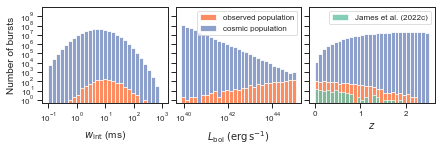

In [40]:
n_frbs = 1000

# for survey_model, beam_model, z_model, z_max, bol_lum_low in all_runs:

# Define the names of files to be saved. Consider the special cases of CRACO.
if isinstance(survey_model, str):
    file = f"Simulated_FRBs/{survey_model}_{z_model}.pickle"
    fig_name = f"Simulated_FRBs/{survey_model}_{z_model}.png"
else:
    file = f"Simulated_FRBs/askap-craco_{z_model}.pickle"
    fig_name = f"Simulated_FRBs/askap-craco_{z_model}.png"

# Make a new file if non-existend pickle file
if os.path.isfile(file):
    frbs = np.load(file, allow_pickle=True)
else:
    frbs = pd.DataFrame()
    print("Starting a new FRB population")

i = 0
while (frbs.shape[0] < n_frbs and i < 100) or i == 0:
    try:
        # Free workspace. Somehow this is not done automatically.
        del(cosmic_pop)
        gc.collect()
    except:
        pass
    energy_high = 10**41.88  # James et al. 2022 with alpha as rate but with uniform prior
    specif_lum_high = energy_high/(1e9*0.00267)  # 1GHz bandwidth 5.49ms0.00549
    cosmic_pop, survey_pop = generate_frbs(survey_model, beam_model, z_model=z_model, n_srcs=1e7, z_max=z_max, 
                                           bol_lum_low=bol_lum_low, specif_lum_high=specif_lum_high, w_min=0.)
    frbs = frbs.append(survey_pop.to_df())
    print(survey_pop.n_bursts())
    i += 1
    # Uncomment the following if the code is run on a laptop.
    # if i == 33 or i == 66:  
    #     time.sleep(60*10)

print(frbs.shape[0])

# Make a three panel plot with different generated parameter distributions.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(textwidth, textwidth/3*4.8/6.4), gridspec_kw={'wspace': 0.06})

palette = sns.color_palette('Set2')

wbins = np.logspace(-1, 3., 30)
histo, bins = np.histogram(cosmic_pop.frbs.w_int, bins=wbins)
ax1.bar(bins[:-1], 1000//survey_pop.n_bursts()*histo, width=np.diff(bins), align='edge', label='cosmic population', color=palette[2])
ax1.hist(frbs['w_int'], density=False, bins=wbins, alpha=1., color=palette[1], label='observed population')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$w_\mathrm{int}$ (ms)')
ax1.set_ylabel('Number of bursts')
ax1.set_xticks([.1, 1, 10, 100, 1e3])

# Luminosity
l_min, l_max = cosmic_pop.frbs.lum_bol.min(), cosmic_pop.frbs.lum_bol.max()
lbins = np.logspace(np.log10(l_min), np.log10(l_max), 30)
histo, bins = np.histogram(cosmic_pop.frbs.lum_bol, bins=lbins)

ax2.bar(bins[:-1], 1000//survey_pop.n_bursts()*histo, width=np.diff(bins), align='edge', color=palette[2], label='cosmic population')
ax2.hist(frbs['lum_bol'], density=False, bins=lbins, alpha=1, color=palette[1], label='observed population')
ax2.set_xscale('log')
ax2.set_yscale('log')
#ax2.set_title('Bolometric luminosity')
ax2.set_xlabel(r'$L_\mathrm{bol} \;(\mathrm{erg\,s}^{-1})$')
ax2.set_xticks([1e40, 1e42, 1e44])
ax2.legend()

# Redshift
histo, bins = np.histogram(cosmic_pop.frbs.z, bins=30, range=(0, cosmic_pop.frbs.z.max()))

ax3.bar(bins[:-1], 1000//survey_pop.n_bursts()*histo, align='edge', width=np.diff(bins), color=palette[2])
#n, bins, patches = ax3.hist(cosmic_pop.frbs.z, density=False, bins=30, alpha=1.)  #bins=bins,
ax3.hist(frbs['z'], density=False, bins=bins, alpha=1., color=palette[1])

# Add simulated FRBs from James et al.
james_zs = james_frbs.reshape((100,3))[:, 2]
if bins[-1] < james_zs.max():
    nbins = np.ceil(james_zs.max()/(bins[1]-bins[0]))
    bins = np.linspace(0, nbins*(bins[1]-bins[0]), num=int(nbins))
ax3.hist(james_zs, density=False, bins=bins, alpha=.8, color=palette[0], label="James et al. (2022c)")
ax3.set_yscale('log')
#ax3.set_xlim(0, 4)
ax3.set_xlabel('$z$')
ax3.set_ylim(0.5, 1e10)
ax3.set_yticks([1, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9])
ax3.legend()

fig.savefig(fig_name, dpi=300, bbox_inches='tight')
plt.show()
#time.sleep(60*20)  # 20 minutes break to prevent overheating